In [6]:
# 1. Necessary Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [7]:
# 2. Custom Dataset Classes
class HospitalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [8]:
class InsuranceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 4. Load Data and Preprocess
df_hospital = pd.read_csv('datasets/final_hospital.csv')  # Hospital dataset path
df_insurance = pd.read_csv('datasets/final_insurance.csv')  # Insurance dataset path


C:\Users\maha3\AppData\Local\Temp\ipykernel_11620\3394093481.py:13: DtypeWarning: Columns (9,12,13,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hospital = pd.read_csv('datasets/final_hospital.csv')  # Hospital dataset path
C:\Users\maha3\AppData\Local\Temp\ipykernel_11620\3394093481.py:14: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_insurance = pd.read_csv('datasets/final_insurance.csv')  # Insurance dataset path


In [9]:

# 3. Preprocessing Functions
def preprocess_hospital_data(df):
    df = df.dropna(subset=['risc_score'])  # Remove NaN target rows
    numeric_features = ['StayDuration', 'UniqueDiagnosisCount']
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    print(df[numeric_features].dtypes)
    return df



In [10]:
def preprocess_insurance_data(df):
    df = df.dropna(subset=['claim_amount'])  # Remove NaN target rows
    numeric_features = ['IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt']
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    print(df[numeric_features].dtypes)
    return df

In [15]:
df_hospital = preprocess_hospital_data(df_hospital)
df_insurance = preprocess_insurance_data(df_insurance)

StayDuration            float64
UniqueDiagnosisCount    float64
dtype: object
IPAnnualReimbursementAmt    float64
OPAnnualReimbursementAmt    float64
dtype: object


In [19]:
# Implementing categorization and decision logic (To be trained)
def categorize_risk(risc_score):
    if 0.7 <= risc_score < 4.3:
        return 'low_risk'
    elif 4.3 <= risc_score < 7.9:
        return 'moderate_risk'
    elif 7.9 <= risc_score <= 14.5:
        return 'high_risk'
    else:
        return 'unknown'

In [20]:
def categorize_claim(claim_amount):
    if 1000.0 <= claim_amount < 50000.83:
        return 'low_claim'
    elif 50000.83 <= claim_amount < 100000.66:
        return 'medium_claim'
    elif 100000.66 <= claim_amount <= 261219.5:
        return 'high_claim'
    else:
        return 'unknown'
#this is the catigorization logic and this is this decision logic # Decision dictionary to categorize claims
decision_dict = {
    ('low_risk', 'low_claim'): 'legitimate',
    ('low_risk', 'medium_claim'): 'review',
    ('low_risk', 'high_claim'): 'fraudulent',
    ('moderate_risk', 'low_claim'): 'legitimate',
    ('moderate_risk', 'medium_claim'): 'legitimate',
    ('moderate_risk', 'high_claim'): 'review',
    ('high_risk', 'low_claim'): 'review',
    ('high_risk', 'medium_claim'): 'review',
    ('high_risk', 'high_claim'): 'fraudulent'
}


In [21]:
# Apply categorization and decision logic
df_hospital['risk_category'] = df_hospital['risc_score'].apply(categorize_risk)

df_insurance['claim_category'] = df_insurance['claim_amount'].apply(categorize_claim)

In [22]:
# Define features and target
X_hospital = df_hospital[['StayDuration', 'UniqueDiagnosisCount']]
y_hospital = df_hospital['risk_category'].map({'low_risk': 0, 'moderate_risk': 1, 'high_risk': 2})
X_insurance = df_insurance[['IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt']]
y_insurance = df_insurance['claim_category'].map({'low_claim': 0, 'medium_claim': 1, 'high_claim': 2})

In [23]:
# Split data
X_hospital_train, X_hospital_test, y_hospital_train, y_hospital_test = train_test_split(
    X_hospital, y_hospital, test_size=0.2, random_state=42
)
X_insurance_train, X_insurance_test, y_insurance_train, y_insurance_test = train_test_split(
    X_insurance, y_insurance, test_size=0.2, random_state=42
)

In [24]:
# Create Datasets and DataLoaders
hospital_train_dataset = HospitalDataset(X_hospital_train, y_hospital_train)
hospital_test_dataset = HospitalDataset(X_hospital_test, y_hospital_test)
insurance_train_dataset = InsuranceDataset(X_insurance_train, y_insurance_train)
insurance_test_dataset = InsuranceDataset(X_insurance_test, y_insurance_test)

In [25]:
batch_size = 64
hospital_train_loader = DataLoader(hospital_train_dataset, batch_size=batch_size, shuffle=True)
hospital_test_loader = DataLoader(hospital_test_dataset, batch_size=batch_size, shuffle=False)
insurance_train_loader = DataLoader(insurance_train_dataset, batch_size=batch_size, shuffle=True)
insurance_test_loader = DataLoader(insurance_test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
import torch
import torch.nn as nn

# Define the FraudNetX class
class FraudNetX(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FraudNetX, self).__init__()
        # Define layers
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)  # Keep the hidden_size here for consistency with transformer input
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4), num_layers=2
        )
        # Add final linear layer to project transformer output to num_classes
        self.fc_out = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Process input through FFNN
        x_ffnn = self.ffnn(x)  # The output is of shape (batch_size, hidden_size)
        
        # Reshape the output for the transformer to have the shape (batch_size, seq_len, embedding_dim)
        x_ffnn = x_ffnn.unsqueeze(1)  # Add a sequence length dimension, resulting in shape (batch_size, 1, hidden_size)
        
        # Pass through transformer for sequential pattern learning (assuming x is suitable for this)
        x_transformed = self.transformer(x_ffnn)
        
        # Use only the first token (or any specific token) from the transformer output for classification
        x_transformed = x_transformed.squeeze(1)  # Remove the sequence length dimension, resulting in shape (batch_size, hidden_size)
        
        # Pass through the final fully connected layer
        x_out = self.fc_out(x_transformed)  # Output shape: (batch_size, num_classes)
        
        return x_out


In [27]:
# 6. Training Function
def train_model(model, dataloader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

In [28]:
# 7. Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    return classification_report(all_labels, all_preds, output_dict=True), all_preds

In [29]:
# 8. Initialize Models, Optimizers, and Criterion
model_hospital = FraudNetX(input_size=2, hidden_size=64, num_classes=3)
model_insurance = FraudNetX(input_size=2, hidden_size=64, num_classes=3)

c:\Users\maha3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [30]:
class_weights = torch.tensor([1.0, 2.0, 3.0])  # Higher weight for minority classes
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer_hospital = torch.optim.Adam(model_hospital.parameters(), lr=0.001)
optimizer_insurance = torch.optim.Adam(model_insurance.parameters(), lr=0.001)

In [32]:
# Train Hospital Model
train_model(model_hospital, hospital_train_loader, optimizer_hospital, criterion)

# Train Insurance Model
train_model(model_insurance, insurance_train_loader, optimizer_insurance, criterion)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Epoch [1/5], Loss: 0.0098
Epoch [2/5], Loss: 0.0066
Epoch [3/5], Loss: 0.0060
Epoch [4/5], Loss: 0.0056
Epoch [5/5], Loss: 0.0055
Epoch [1/5], Loss: 0.0103
Epoch [2/5], Loss: 0.0059
Epoch [3/5], Loss: 0.0047
Epoch [4/5], Loss: 0.0038
Epoch [5/5], Loss: 0.0038


In [33]:
# Function to apply Differential Privacy noise (Gaussian or Laplace)
def apply_dp_noise(tensor, noise_factor=0.01, noise_type='gaussian'):
    noise = torch.randn_like(tensor) * noise_factor if noise_type == 'gaussian' else torch.empty_like(tensor).laplace_(0, noise_factor)
    return tensor + noise

In [34]:
# Federated Averaging Algorithm
def federated_averaging(global_model, client_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key] for i in range(len(client_models))]).mean(dim=0)
    global_model.load_state_dict(global_dict)
    return global_model

In [35]:
# Federated Training Loop
def federated_training(num_rounds, num_clients, global_model, client_dataloaders, device='cpu', noise_factor=0.01, noise_type='gaussian'):
    client_models = [FraudNetX(input_size=2, hidden_size=64, num_classes=3).to(device) for _ in range(num_clients)]
    optimizers = [optim.Adam(client_models[i].parameters(), lr=0.001) for i in range(num_clients)]
    criterion = nn.CrossEntropyLoss()

    for round in range(num_rounds):
        for client_idx in range(num_clients):
            model = client_models[client_idx]
            model.load_state_dict(global_model.state_dict())  # Sync with global model
            model.train()

            for batch_idx, (inputs, labels) in enumerate(client_dataloaders[client_idx]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizers[client_idx].zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                
                # Apply DP noise to gradients
                for param in model.parameters():
                    if param.grad is not None:
                        param.grad = apply_dp_noise(param.grad, noise_factor, noise_type)
                
                optimizers[client_idx].step()
        
        # Aggregate models using Federated Averaging
        global_model = federated_averaging(global_model, client_models)
        print(f"Round {round+1} completed")
    
    return global_model

In [36]:
# Initialize global model
global_model = FraudNetX(input_size=2, hidden_size=64, num_classes=3).to('cpu')

c:\Users\maha3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [37]:
# Define client data loaders
client_dataloaders = [hospital_train_loader, insurance_train_loader]

In [38]:
trained_model = federated_training(num_rounds=5, num_clients=2, global_model=global_model, client_dataloaders=client_dataloaders, device='cpu', noise_factor=0.05, noise_type='gaussian')

Round 1 completed
Round 2 completed
Round 3 completed
Round 4 completed
Round 5 completed


In [39]:
hospital_report, hospital_preds = evaluate_model(trained_model, hospital_test_loader)
insurance_report, insurance_preds = evaluate_model(trained_model, insurance_test_loader)

print("Hospital Model Evaluation:\n", hospital_report)
print("Insurance Model Evaluation:\n", insurance_report)


Hospital Model Evaluation:
 {'0': {'precision': 0.9887799684253038, 'recall': 1.0, 'f1-score': 0.9943583343794538, 'support': 134657.0}, '1': {'precision': 0.9584120982986768, 'recall': 0.5687044307347168, 'f1-score': 0.7138331573389651, 'support': 3566.0}, '2': {'precision': 0.9761904761904762, 'recall': 0.8232931726907631, 'f1-score': 0.8932461873638344, 'support': 498.0}, 'accuracy': 0.988278631209406, 'macro avg': {'precision': 0.9744608476381522, 'recall': 0.79733253447516, 'f1-score': 0.8671458930274177, 'support': 138721.0}, 'weighted avg': {'precision': 0.9879541281271191, 'recall': 0.988278631209406, 'f1-score': 0.9867840908940393, 'support': 138721.0}}
Insurance Model Evaluation:
 {'0': {'precision': 0.9996895770944416, 'recall': 0.9983041575492342, 'f1-score': 0.9989963869931754, 'support': 54840.0}, '1': {'precision': 0.8442211055276382, 'recall': 0.9180327868852459, 'f1-score': 0.8795811518324608, 'support': 549.0}, '2': {'precision': 0.5483870967741935, 'recall': 1.0, 'f1

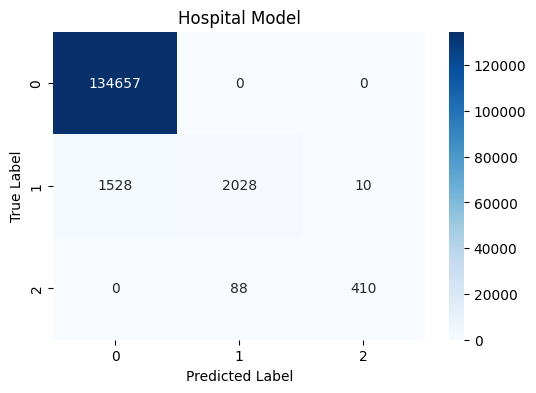

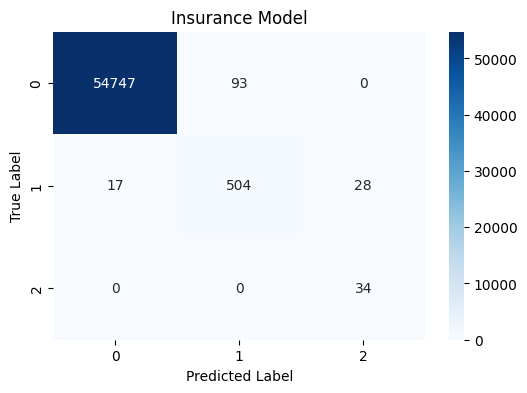

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_hospital_test, hospital_preds, "Hospital Model")
plot_confusion_matrix(y_insurance_test, insurance_preds, "Insurance Model")


In [41]:
from collections import Counter

# Define the decision dictionary for fraud detection
decision_dict = {
    ('low_risk', 'low_claim'): 'Legitimate',
    ('low_risk', 'medium_claim'): 'Review',
    ('low_risk', 'high_claim'): 'Fraudulent',
    ('moderate_risk', 'low_claim'): 'Legitimate',
    ('moderate_risk', 'medium_claim'): 'Review',
    ('moderate_risk', 'high_claim'): 'Fraudulent',
    ('high_risk', 'low_claim'): 'Legitimate',
    ('high_risk', 'medium_claim'): 'Review',
    ('high_risk', 'high_claim'): 'Fraudulent',
}

In [42]:
# Define the function to apply the decision logic
def apply_decision_logic(risk_category, claim_category):
    return decision_dict.get((risk_category, claim_category), 'unknown')


In [43]:
# Map Hospital Model predictions to risk categories
hospital_risk_predictions = hospital_preds  # Model predictions for risk (0: low_risk, 1: moderate_risk, 2: high_risk)
hospital_risk_labels = ['low_risk', 'moderate_risk', 'high_risk']
hospital_risk_categories = [hospital_risk_labels[pred] for pred in hospital_risk_predictions]

In [44]:
# Map Insurance Model predictions to claim categories
insurance_claim_predictions = insurance_preds  # Model predictions for claim (0: low_claim, 1: medium_claim, 2: high_claim)
insurance_claim_labels = ['low_claim', 'medium_claim', 'high_claim']
insurance_claim_categories = [insurance_claim_labels[pred] for pred in insurance_claim_predictions]

In [45]:
# Apply Decision Logic for Hospital
hospital_fraud_detection = [
    apply_decision_logic(risk_category, 'low_claim')  # Assuming 'low_claim' for simplicity, you can update with actual claim category
    for risk_category in hospital_risk_categories
]

In [46]:
# Apply Decision Logic for Insurance
insurance_fraud_detection = [
    apply_decision_logic('low_risk', claim_category)  # Assuming 'low_risk' for simplicity, you can update with actual risk category
    for claim_category in insurance_claim_categories
]

In [47]:
# Count the results for Hospital Fraud Detection
hospital_fraud_count = Counter(hospital_fraud_detection)

In [48]:
# Count the results for Insurance Fraud Detection
insurance_fraud_count = Counter(insurance_fraud_detection)

In [49]:
# Combine the counts from both datasets
combined_fraud_count = {
    'Legitimate': hospital_fraud_count['Legitimate'] + insurance_fraud_count['Legitimate'],
    'Review': hospital_fraud_count['Review'] + insurance_fraud_count['Review'],
    'Fraudulent': hospital_fraud_count['Fraudulent'] + insurance_fraud_count['Fraudulent']
}

In [50]:
# Display the combined counts
print("Combined Fraud Detection Results Count:")
print(f"Legitimate: {combined_fraud_count['Legitimate']}")
print(f"Review: {combined_fraud_count['Review']}")
print(f"Fraudulent: {combined_fraud_count['Fraudulent']}")

Combined Fraud Detection Results Count:
Legitimate: 193485
Review: 597
Fraudulent: 62


In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [51]:
# 1. Evaluate the metrics for both Hospital and Insurance models
def evaluate_metrics(predictions, true_labels):
    # Calculate precision, recall, F1 score, support, and accuracy
    precision, recall, fscore, support = precision_recall_fscore_support(true_labels, predictions, average=None)
    accuracy = accuracy_score(true_labels, predictions)
    
    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': fscore,
        'Support': support,
        'Accuracy': [accuracy] * len(precision)  # Accuracy is the same for all categories
    }, index=['Legitimate', 'Review', 'Fraudulent'])
    
    return metrics_df

In [52]:
# 2. Get the evaluation metrics for Hospital and Insurance models
hospital_metrics = evaluate_metrics(hospital_preds, y_hospital_test)
insurance_metrics = evaluate_metrics(insurance_preds, y_insurance_test)

In [53]:
# 3. Combine the evaluation metrics into one DataFrame for visualization
# Use `keys` to properly set multi-level columns
combined_metrics = pd.concat([hospital_metrics, insurance_metrics], axis=1, keys=['Hospital', 'Insurance'])

In [ ]:
# Now combined_metrics should contain metrics for both Hospital and Insurance models
# Display the combined metrics DataFrame to check
print(combined_metrics)


            Hospital                                       Insurance  \
           Precision    Recall  F1-Score Support  Accuracy Precision   
Legitimate  0.988780  1.000000  0.994358  134657  0.988279  0.999690   
Review      0.958412  0.568704  0.713833    3566  0.988279  0.844221   
Fraudulent  0.976190  0.823293  0.893246     498  0.988279  0.548387   

                                                 
              Recall  F1-Score Support Accuracy  
Legitimate  0.998304  0.998996   54840  0.99751  
Review      0.918033  0.879581     549  0.99751  
Fraudulent  1.000000  0.708333      34  0.99751  


C:\Users\maha3\AppData\Local\Temp\ipykernel_11620\1066913708.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(combined_fraud_count.keys()), y=list(combined_fraud_count.values()), palette="Blues")


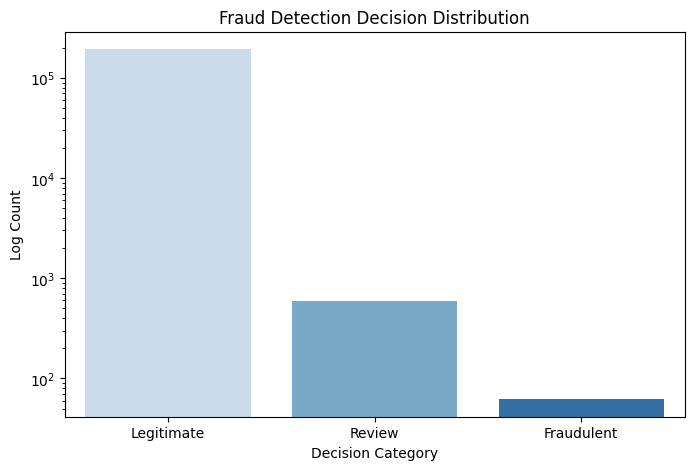

In [59]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(combined_fraud_count.keys()), y=list(combined_fraud_count.values()), palette="Blues")
plt.yscale('log')  # Apply log scale to Y-axis
plt.title("Fraud Detection Decision Distribution")
plt.xlabel("Decision Category")
plt.ylabel("Log Count")
plt.show()

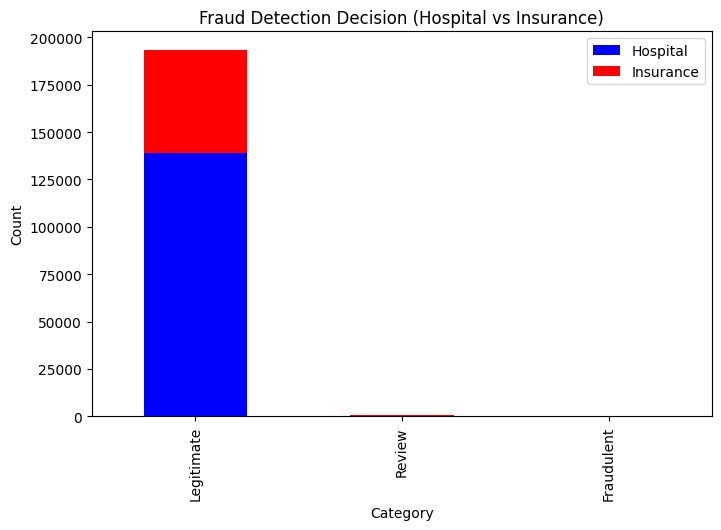

In [61]:
fraud_decisions_df = pd.DataFrame({'Category': ['Legitimate', 'Review', 'Fraudulent'],
                                   'Hospital': [hospital_fraud_count['Legitimate'], 
                                                hospital_fraud_count['Review'], 
                                                hospital_fraud_count['Fraudulent']],
                                   'Insurance': [insurance_fraud_count['Legitimate'], 
                                                 insurance_fraud_count['Review'], 
                                                 insurance_fraud_count['Fraudulent']]})

fraud_decisions_df.set_index("Category").plot(kind="bar", stacked=True, color=['blue', 'red'], figsize=(8, 5))
plt.title("Fraud Detection Decision (Hospital vs Insurance)")
plt.ylabel("Count")
plt.show()


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch

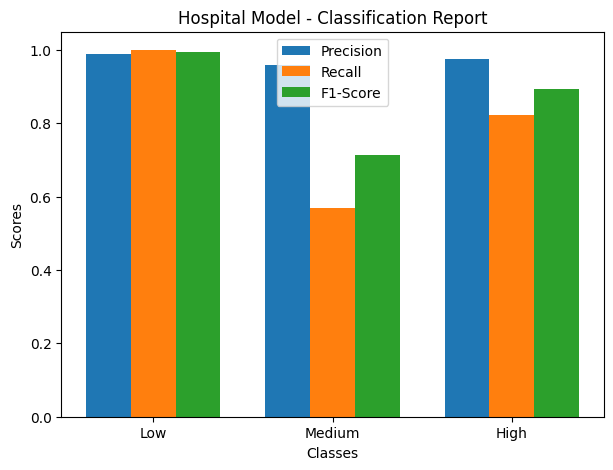

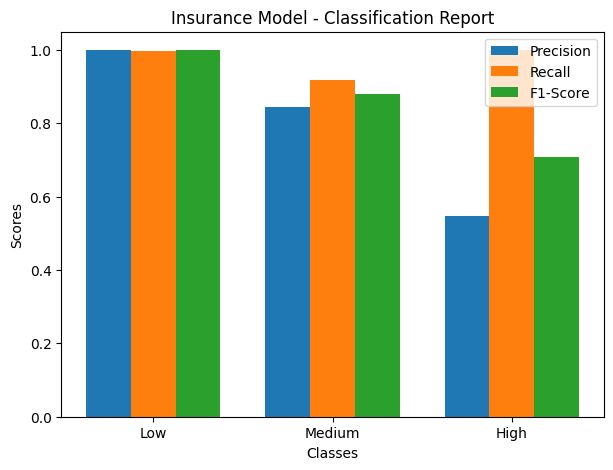

In [75]:
import numpy as np

def plot_classification_report(report, model_name):
    labels = ["Low", "Medium", "High"]
    precision = [report[str(i)]['precision'] for i in range(3)]
    recall = [report[str(i)]['recall'] for i in range(3)]
    f1_score = [report[str(i)]['f1-score'] for i in range(3)]

    x = np.arange(len(labels))  # Label locations
    width = 0.25  # Bar width

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(x - width, precision, width, label="Precision")
    ax.bar(x, recall, width, label="Recall")
    ax.bar(x + width, f1_score, width, label="F1-Score")

    ax.set_xlabel("Classes")
    ax.set_ylabel("Scores")
    ax.set_title(f"{model_name} Model - Classification Report")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

# Plot classification report for both models
plot_classification_report(hospital_report, "Hospital")
plot_classification_report(insurance_report, "Insurance")


Hospital Labels: 138721, Predictions: 138721
Insurance Labels: 55423, Predictions: 55423


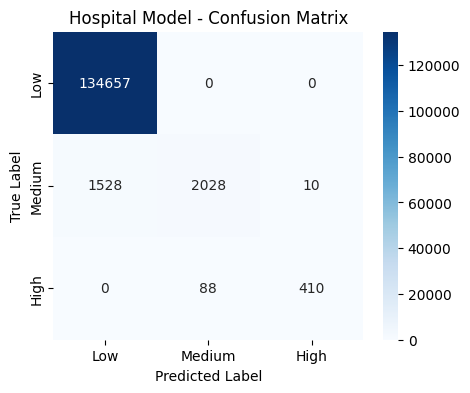

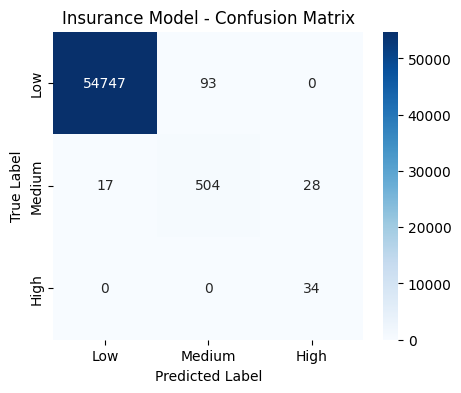

In [78]:
import torch

# Extract true labels from DataLoader properly
def get_all_labels(dataloader):
    y_true = []
    for _, labels in dataloader:  # Extract labels from each batch
        y_true.extend(labels.cpu().numpy())  # Convert tensors to NumPy and extend
    return y_true

# Correct extraction
hospital_y_true = get_all_labels(hospital_test_loader)
insurance_y_true = get_all_labels(insurance_test_loader)

# Ensure lengths match
print(f"Hospital Labels: {len(hospital_y_true)}, Predictions: {len(hospital_preds)}")
print(f"Insurance Labels: {len(insurance_y_true)}, Predictions: {len(insurance_preds)}")

# Now plot confusion matrix
plot_confusion_matrix(hospital_y_true, hospital_preds, "Hospital")
plot_confusion_matrix(insurance_y_true, insurance_preds, "Insurance")


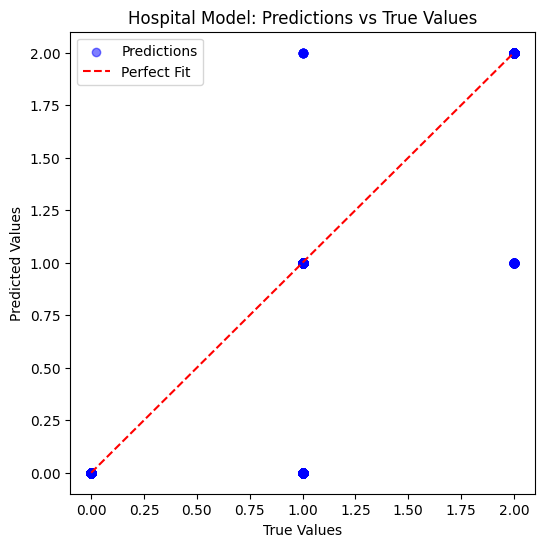

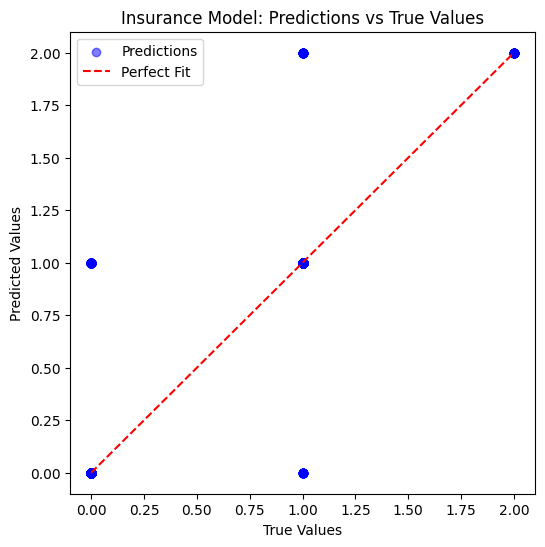

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_plot(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label="Predictions")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', label="Perfect Fit")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{title}: Predictions vs True Values")
    plt.legend()
    plt.show()

# Convert lists to NumPy arrays
hospital_y_true = np.array(hospital_y_true)
hospital_preds = np.array(hospital_preds)
insurance_y_true = np.array(insurance_y_true)
insurance_preds = np.array(insurance_preds)

# Plot for Hospital and Insurance Data
scatter_plot(hospital_y_true, hospital_preds, "Hospital Model")
scatter_plot(insurance_y_true, insurance_preds, "Insurance Model")
